In [7]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [8]:
import os
import sys

# ============================================================================
# CONFIGURACIÓN DE DIRECTORIOS
# ============================================================================

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    project_dir = '/content/TFMDS'
    os.chdir(project_dir)
else:
    project_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(project_dir)

# Agregar el directorio del proyecto al path de Python
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

print("Directorio de trabajo:", os.getcwd())
print("Python path incluye proyecto:", project_dir in sys.path)

Directorio de trabajo: C:\Users\jmora\Documents\TFMDS
Python path incluye proyecto: True


In [9]:

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost.callback import EarlyStopping
import warnings
import time
warnings.filterwarnings('ignore')



# ============================================================================
# IMPORTAR FUNCIONES PERSONALIZADAS
# ============================================================================

from lib.metricas import calcular_metricas, comparar_metricas, resumen_metricas, agregar_estadisticas_error
from lib.graficos import (grafico_real_vs_prediccion, grafico_scatter_prediccion, grafico_comparacion_metricas,
                          grafico_distribucion_error, grafico_feature_importance, dashboard_prediccion)


## Lectura de fichero y adaptación de los tipos


In [10]:

# ============================================================================
# LECTURA DE DATOS
# ============================================================================

df_train = pd.read_csv('datos/df_train.csv', sep=';', parse_dates=['idSecuencia'])
df_test = pd.read_csv('datos/df_test.csv', sep=';', parse_dates=['idSecuencia'])

print("\nInformación de las columnas y tipos de datos:")
print(df_train.info())
print(df_test.info())



Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625800 entries, 0 to 625799
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idSecuencia         625800 non-null  datetime64[ns]
 1   producto            625800 non-null  int64         
 2   udsVenta            625800 non-null  int64         
 3   bolPromocion        625800 non-null  int64         
 4   bolOpen             625800 non-null  int64         
 5   bolHoliday          625800 non-null  int64         
 6   udsStock            625800 non-null  int64         
 7   rotura_stock        625800 non-null  bool          
 8   dia_semana          625800 non-null  int64         
 9   mes                 625800 non-null  int64         
 10  trimestre           625800 non-null  int64         
 11  lag_ventas_1        625800 non-null  float64       
 12  lag_ventas_2        625800 non-null  fl

# XGBoost

- Determinar características utilizar FEATURES
- Descomponer serie en Train y Test
- Características a Normalizar/Estandarizar o codificar
- Crear modelos estimando hiperparámetros
- Valorar modelos




In [11]:

# Eliminar días que la tienda está cerrada
df_train = df_train[df_train['bolOpen'] == 1].copy()
df_test = df_test[df_test['bolOpen'] == 1].copy()


In [12]:

# ============================================================================
# CONFIGURACIÓN INICIAL
# ============================================================================

FEATURES = [
    'producto_encoded', 'bolPromocion', 'bolHoliday', 'Cluster',
    'dia_semana', 'mes', 'trimestre',
    'lag_ventas_1', 'lag_ventas_2', 'lag_ventas_3', 'lag_ventas_4',
    'lag_ventas_5', 'lag_ventas_6', 'lag_ventas_7',
    'media_mes_anterior', 'EWMA_corto', 'EWMA_largo', 'Tendencia_EWMA'
]

TARGET = 'udsVenta'

todas_metricas = []

print("="*100)
print("🚀 INICIANDO ANÁLISIS COMPLETO DE XGBOOST")
print("="*100)


🚀 INICIANDO ANÁLISIS COMPLETO DE XGBOOST


# XGBoost global

In [13]:
# ============================================================================
# 1. MODELO GLOBAL CON OPTUNA
# ============================================================================

print("\n" + "="*100)
print("🔍 MODELO 1: XGBOOST GLOBAL")
print("="*100)

# Preparar datos
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")

# Último 20% como validación temporal
VAL_SIZE = int(len(X_train) * 0.2)

X_tr = X_train.iloc[:-VAL_SIZE]
y_tr = y_train.iloc[:-VAL_SIZE]

X_val = X_train.iloc[-VAL_SIZE:]
y_val = y_train.iloc[-VAL_SIZE:]

print(f"\n✅ X_tr shape: {X_tr.shape}")
print(f"✅ X_val shape: {X_val.shape}")
print(f"✅ y_tr shape: {y_tr.shape}")
print(f"✅ y_val shape: {y_val.shape}")


print("\n🔎 Búsqueda de hiperparámetros con Optuna...")

# =====================================================
#  FUNCION OBJETIVO DE OPTUNA PARA XGBOOST
# =====================================================

def objective_xgb(trial):
    # Hiperparámetros
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
        # Añadir eval_metric y early_stopping_rounds al constructor
        "eval_metric": "rmse",
        "early_stopping_rounds": 50
    }

    # Crear el modelo
    model = xgb.XGBRegressor(**params)

    # Entrenar con early stopping - ahora sin esos parámetros en fit()
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Predicciones y cálculo de MSE
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

# =====================================================
#  EJECUTAR OPTUNA
# =====================================================
print("\n🔍 Iniciando optimización de hiperparámetros con Optuna para XGBoost...")
start_time = time.perf_counter()

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=40, n_jobs=1) 

elapsed = time.perf_counter() - start_time
print(f"✅ Optuna completado en {elapsed:.2f} segundos")

print("\n🏆 Mejores hiperparámetros XGBOOST:")
print(study_xgb.best_params)

best_params = study_xgb.best_params.copy()
best_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist", 
    "random_state": 42
})

best_xgb = xgb.XGBRegressor(**best_params)

best_xgb.fit(X_train, y_train)

# Predicciones
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Calcular métricas
metricas_train_global = calcular_metricas(y_train, y_train_pred, 'XGBoost Global Train')
metricas_test_global = calcular_metricas(y_test, y_test_pred, 'XGBoost Global Test')

todas_metricas.append(metricas_test_global)

print("\n📊 Métricas del Modelo Global:")
resumen_metricas([metricas_train_global, metricas_test_global])


[I 2025-11-21 23:40:32,089] A new study created in memory with name: no-name-e74874f8-317c-4136-bbff-913545f9bfef



🔍 MODELO 1: XGBOOST GLOBAL

✅ X_train shape: (521202, 18)
✅ X_test shape: (23244, 18)

✅ X_tr shape: (416962, 18)
✅ X_val shape: (104240, 18)
✅ y_tr shape: (416962,)
✅ y_val shape: (104240,)

🔎 Búsqueda de hiperparámetros con Optuna...

🔍 Iniciando optimización de hiperparámetros con Optuna para XGBoost...


[I 2025-11-21 23:41:00,522] Trial 0 finished with value: 3.8667588233947754 and parameters: {'n_estimators': 805, 'learning_rate': 0.015049626021023874, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.9127907914769839, 'colsample_bytree': 0.748374085568108, 'gamma': 1.1302054785454583, 'reg_lambda': 2.8780283814436456}. Best is trial 0 with value: 3.8667588233947754.
[I 2025-11-21 23:41:06,927] Trial 1 finished with value: 3.875605344772339 and parameters: {'n_estimators': 919, 'learning_rate': 0.06665008893109968, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7148429502088142, 'colsample_bytree': 0.7745305989039, 'gamma': 0.8691479839322009, 'reg_lambda': 1.8436828071281726}. Best is trial 0 with value: 3.8667588233947754.
[I 2025-11-21 23:41:15,283] Trial 2 finished with value: 3.8782742023468018 and parameters: {'n_estimators': 791, 'learning_rate': 0.0516123341422697, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.868562784371826, 'colsample_bytree': 0.6816791

✅ Optuna completado en 911.50 segundos

🏆 Mejores hiperparámetros XGBOOST:
{'n_estimators': 475, 'learning_rate': 0.013778192703924922, 'max_depth': 11, 'min_child_weight': 6, 'subsample': 0.817151374430353, 'colsample_bytree': 0.7474015804395956, 'gamma': 1.8291566781108752, 'reg_lambda': 2.9124866655527373}

📊 Métricas del Modelo Global:

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE    MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
XGBoost Global Train 1.5706 5.3246 2.3075 0.3464     46.29     138.87 0.6687    90.84
 XGBoost Global Test 1.5740 5.6596 2.3790 0.2614     49.26     144.28 0.7291    96.39

🏆 Mejor modelo: XGBoost Global Train (RMSE: 2.3075)


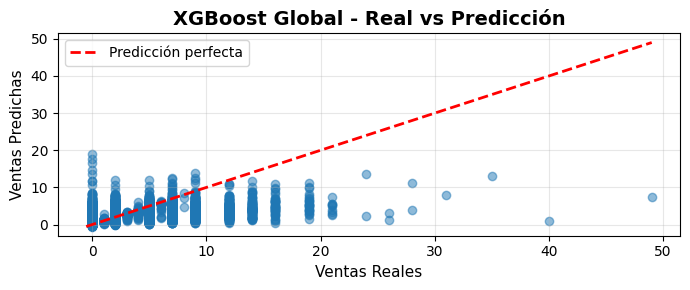

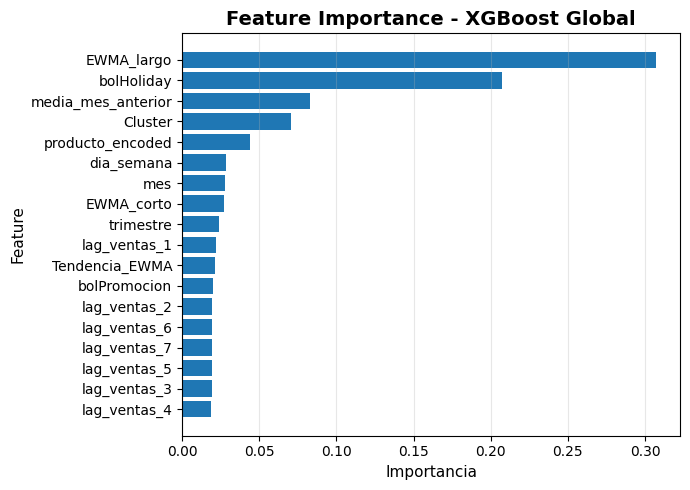

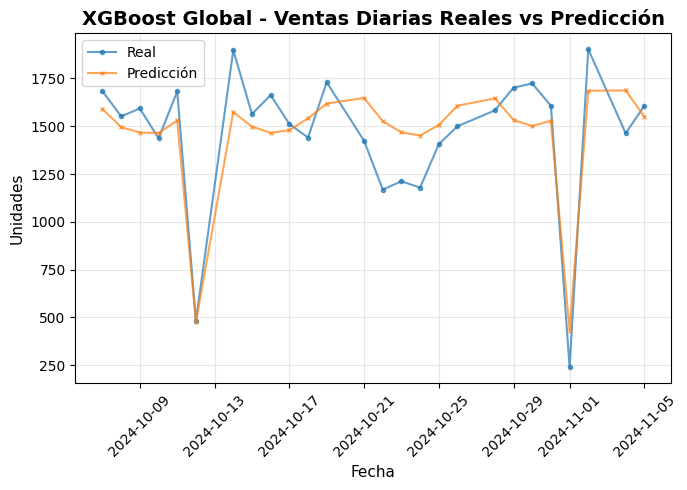

In [14]:

# Visualizaciones del modelo global
df_test_viz = df_test.copy()
df_test_viz['prediccion'] = y_test_pred
df_test_viz['error'] = y_test_pred - df_test_viz[TARGET]

grafico_scatter_prediccion(
    df=df_test_viz,
    col_real=TARGET,
    col_pred='prediccion',
    titulo='XGBoost Global - Real vs Predicción',
    figsize=(7, 3)
)

grafico_feature_importance(
    modelo=best_xgb,
    feature_names=FEATURES,
    top_n=len(FEATURES),
    titulo='Feature Importance - XGBoost Global',
    figsize=(7, 5)
)

# Crear dataframe con suma por día
df_daily = df_test_viz.copy()
df_daily['fecha'] = df_daily['idSecuencia'].dt.date
df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
grafico_real_vs_prediccion(
    df=df_daily_sum,
    col_real=TARGET,
    col_pred='prediccion',
    col_fecha='fecha',
    titulo='XGBoost Global - Ventas Diarias Reales vs Predicción',
    figsize=(7, 5)
)


# XGBoost por Cluster


🔍 MODELO 2: XGBOOST POR CLUSTER

🔄 Entrenando modelo para Cluster 0...
   ✓ MAE: 1.80 | RMSE: 2.56 | R²: 0.1083


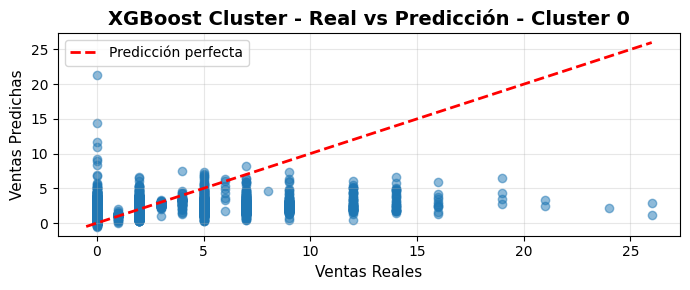

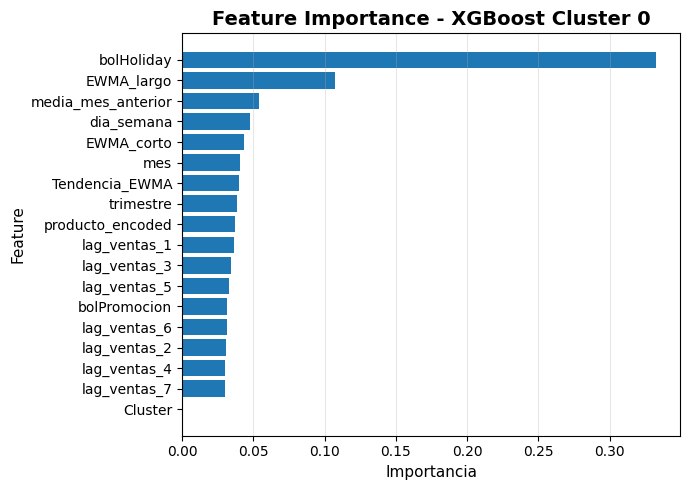

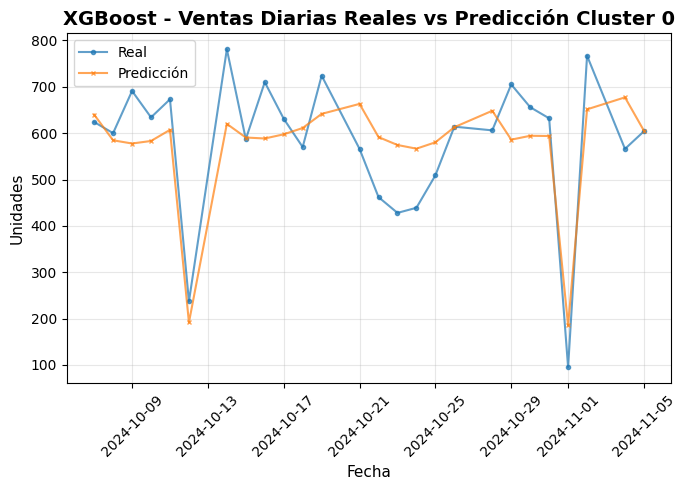


   📌 Producto representativo: 17 (26 registros)
   📊 Estadísticas del error:
      Error medio:             -0.02
      Error abs medio:          1.80
      Error máximo:            24.86


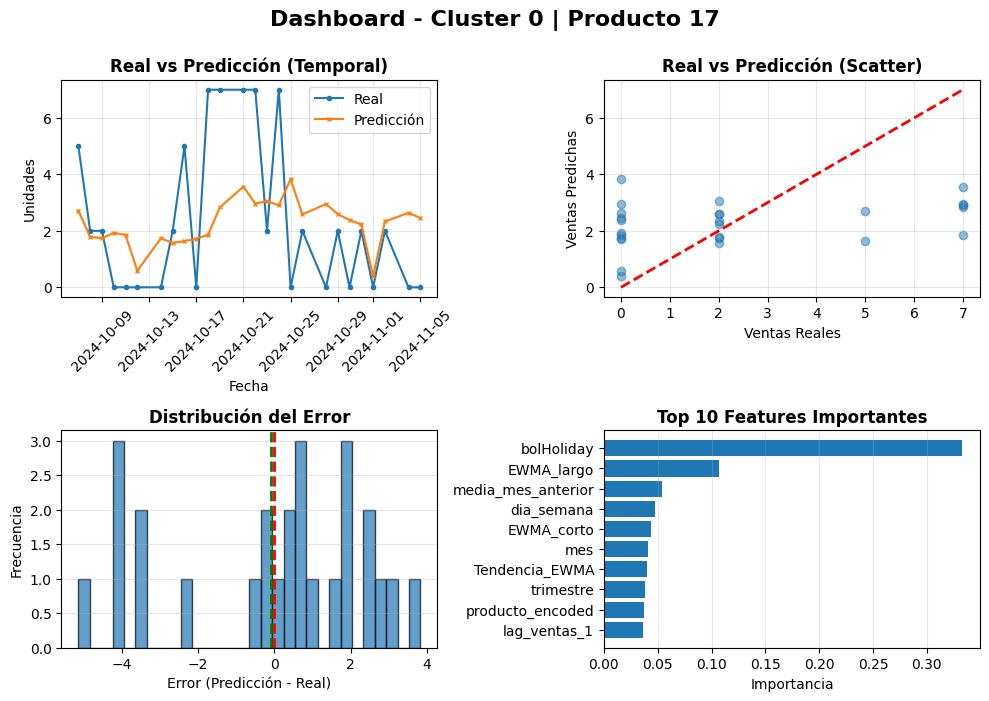


🔄 Entrenando modelo para Cluster 1...
   ✓ MAE: 2.81 | RMSE: 3.61 | R²: 0.1312


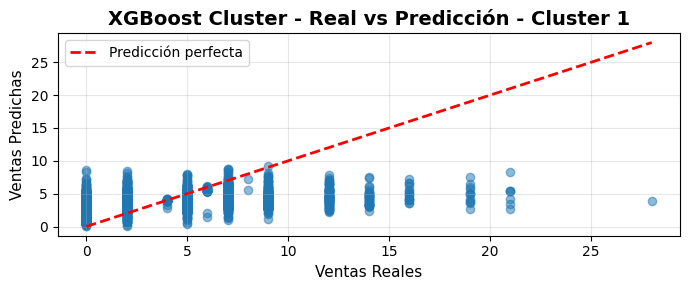

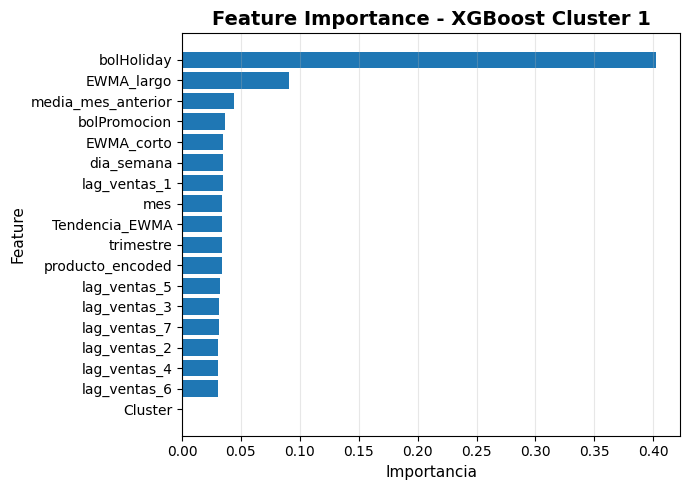

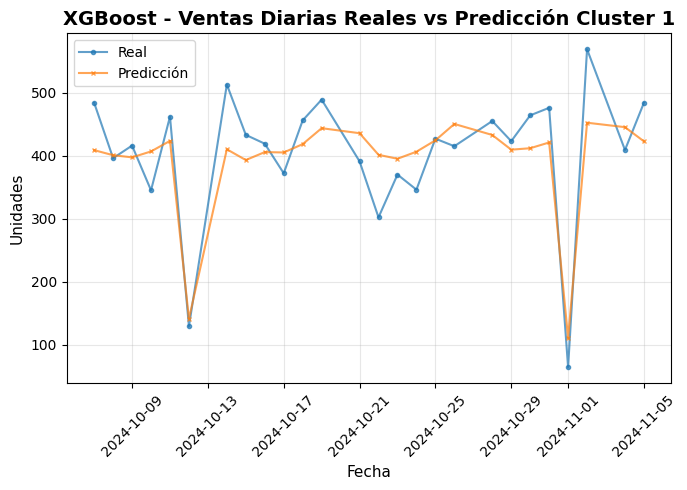


   📌 Producto representativo: 4 (26 registros)
   📊 Estadísticas del error:
      Error medio:             -0.09
      Error abs medio:          2.81
      Error máximo:            24.08


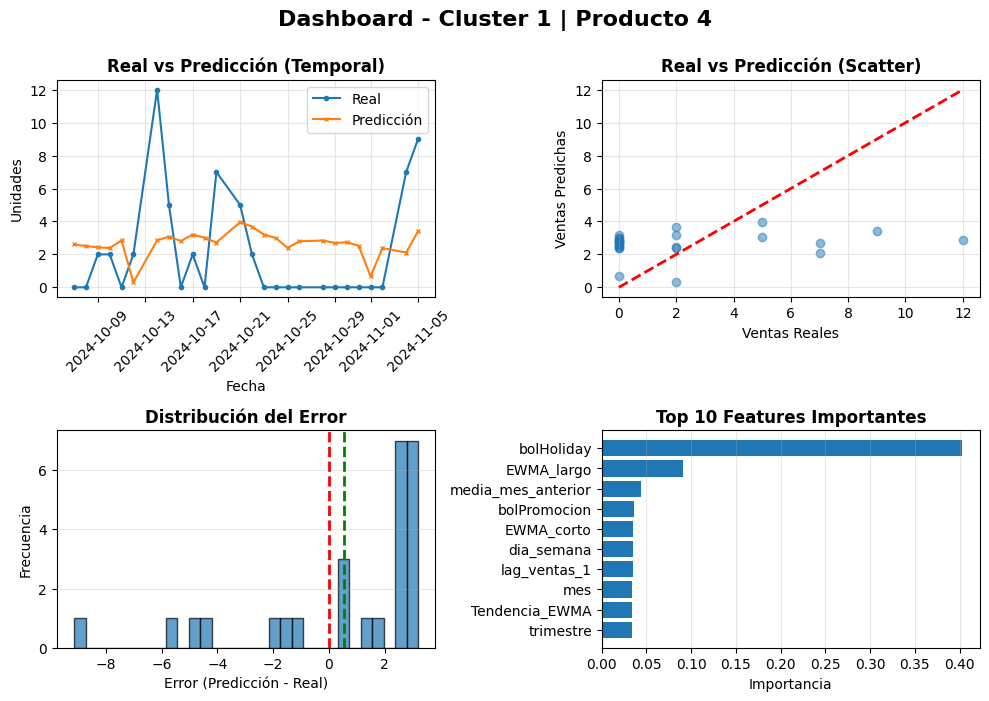


🔄 Entrenando modelo para Cluster 2...
   ✓ MAE: 3.71 | RMSE: 5.11 | R²: 0.1922


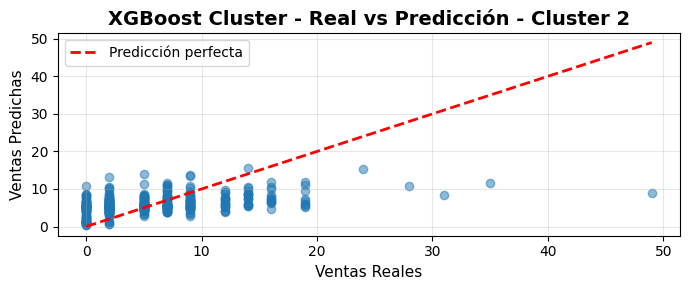

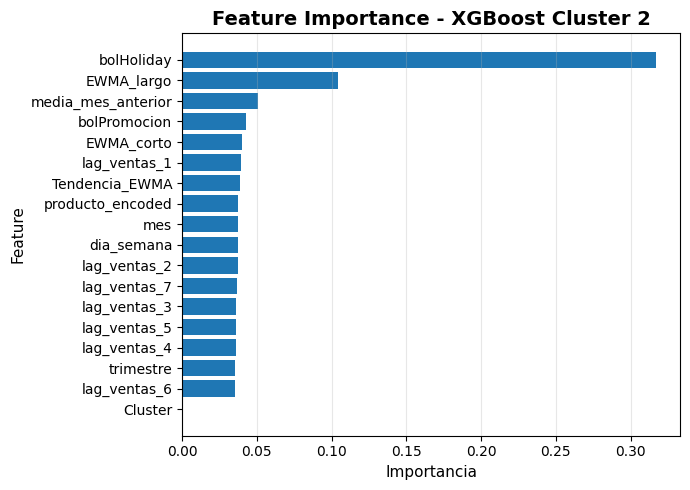

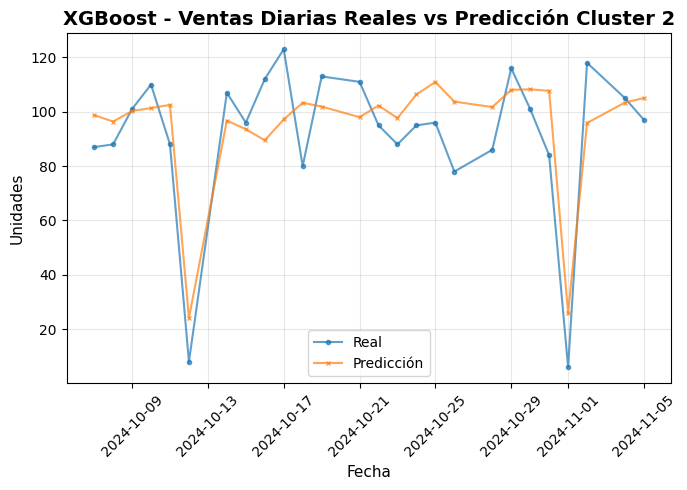


   📌 Producto representativo: 1 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.22
      Error abs medio:          3.71
      Error máximo:            40.13


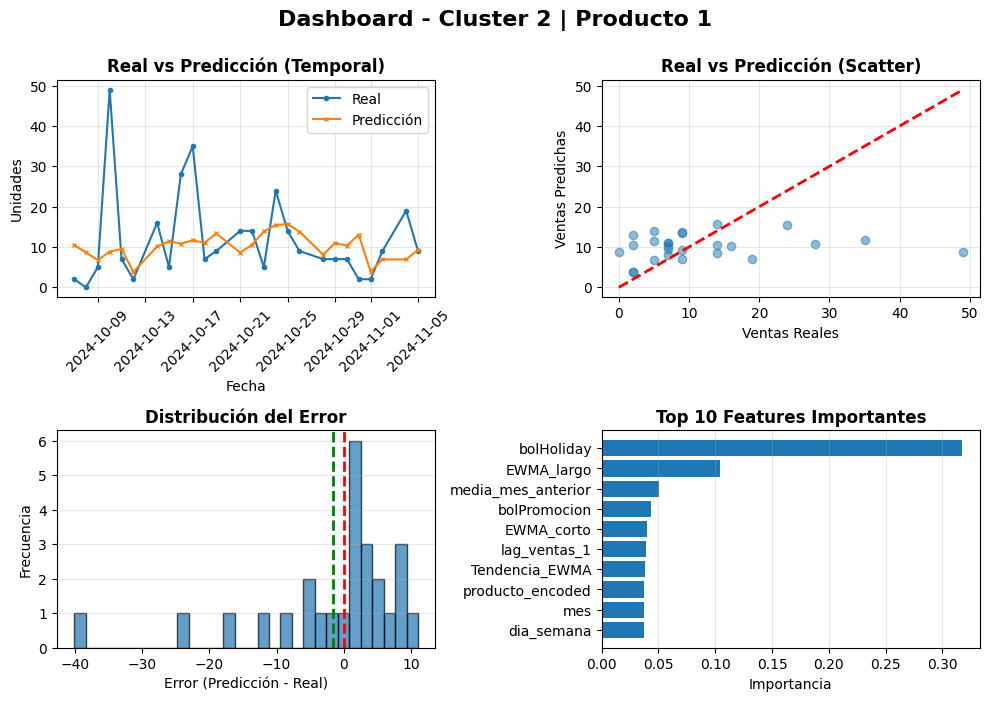


🔄 Entrenando modelo para Cluster 3...
   ✓ MAE: 1.08 | RMSE: 1.66 | R²: 0.0745


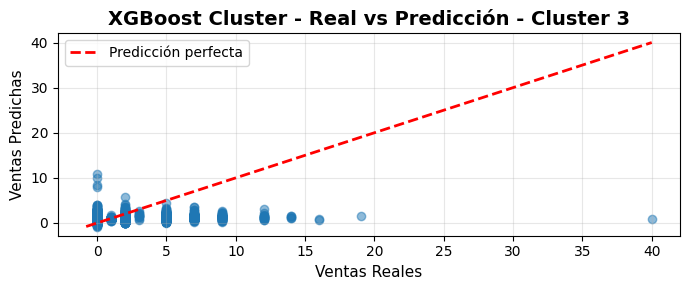

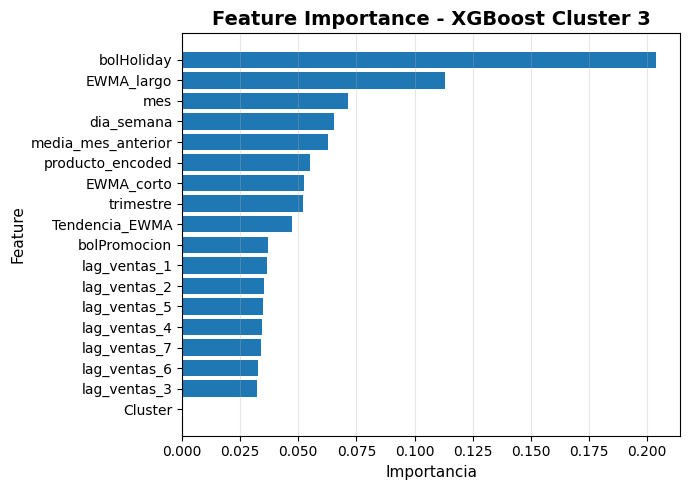

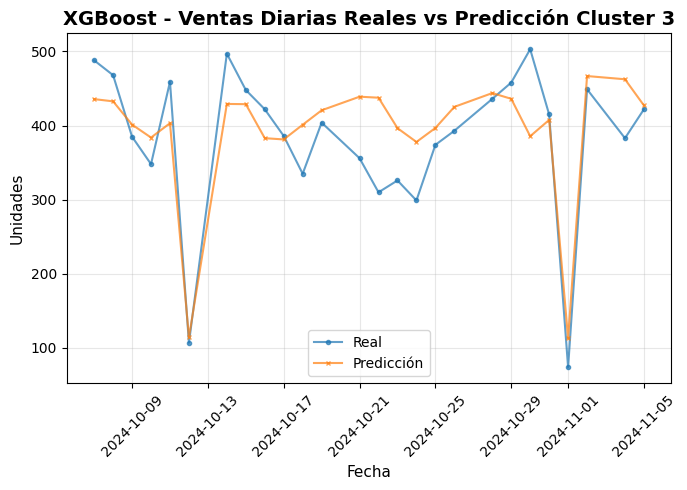


   📌 Producto representativo: 38 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.02
      Error abs medio:          1.08
      Error máximo:            39.02


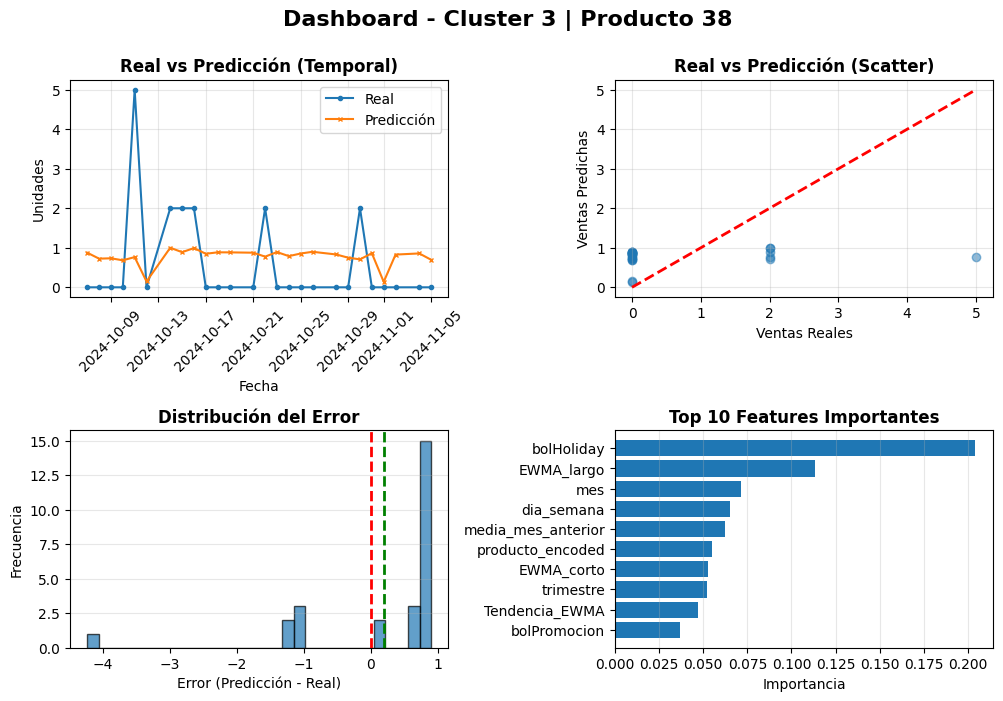

In [15]:

# ============================================================================
# 2. MODELOS POR CLUSTER
# ============================================================================

print("\n" + "="*100)
print("🔍 MODELO 2: XGBOOST POR CLUSTER")
print("="*100)

modelos_cluster = {}

for cluster in sorted(df_train['Cluster'].unique()):
    print(f"\n🔄 Entrenando modelo para Cluster {cluster}...")
    
    # Filtrar datos
    train_cluster = df_train[df_train['Cluster'] == cluster]
    test_cluster = df_test[df_test['Cluster'] == cluster].dropna()
    
    if len(test_cluster) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    X_train_c = train_cluster[FEATURES]
    y_train_c = train_cluster[TARGET]
    X_test_c = test_cluster[FEATURES]
    y_test_c = test_cluster[TARGET]
      
    # Entrenar
        
    xgb_cluster = xgb.XGBRegressor(**best_params)
    
    xgb_cluster.fit(X_train_c, y_train_c)
    y_pred_c = xgb_cluster.predict(X_test_c)
    
    # Calcular métricas
    metricas_cluster = calcular_metricas(y_test_c, y_pred_c, f"XGBoost Cluster {cluster}")
    todas_metricas.append(metricas_cluster)
    
    print(f"   ✓ MAE: {metricas_cluster['MAE']:.2f} | RMSE: {metricas_cluster['RMSE']:.2f} | R²: {metricas_cluster['R2']:.4f}")
    
    # Visualizaciones del modelo cluster
    df_test_viz = test_cluster.copy()
    df_test_viz['prediccion'] = y_pred_c
    df_test_viz['error'] = y_pred_c - df_test_viz[TARGET]

    grafico_scatter_prediccion(
        df=df_test_viz,
        col_real=TARGET,
        col_pred='prediccion',
        titulo=f'XGBoost Cluster - Real vs Predicción - Cluster {cluster}',
        figsize=(7, 3)
    )

    grafico_feature_importance(
        modelo=xgb_cluster,
        feature_names=FEATURES,
        top_n=len(FEATURES),
        titulo=f'Feature Importance - XGBoost Cluster {cluster}',
        figsize=(7, 5)
    )

    # Crear dataframe con suma por día
    df_daily = df_test_viz.copy()
    df_daily['fecha'] = df_daily['idSecuencia'].dt.date
    df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
    grafico_real_vs_prediccion(
        df=df_daily_sum,
        col_real=TARGET,
        col_pred='prediccion',
        col_fecha='fecha',
        titulo=f'XGBoost - Ventas Diarias Reales vs Predicción Cluster {cluster}',
        figsize=(7, 5)
    )
    
    # Preparar datos para visualización de producto representativo
    test_cluster_pred = test_cluster.copy()
    test_cluster_pred['prediccion'] = y_pred_c
    test_cluster_pred['error'] = y_pred_c - test_cluster_pred[TARGET]
    test_cluster_pred['error_abs'] = np.abs(test_cluster_pred['error'])
    
    # Seleccionar producto representativo
    producto_rep = test_cluster['producto'].value_counts().index[0]
    df_producto = test_cluster_pred[test_cluster_pred['producto'] == producto_rep].copy()
    df_producto = df_producto.sort_values('idSecuencia')
    
    print(f"\n   📌 Producto representativo: {producto_rep} ({len(df_producto)} registros)")
    
    # Estadísticas
    print(f"   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_cluster_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_cluster_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_cluster_pred['error_abs'].max():>8.2f}")
    
    dashboard_prediccion(
        df=df_producto,
        col_fecha='idSecuencia',
        col_real=TARGET,
        col_pred='prediccion',
        modelo=xgb_cluster,
        feature_names=FEATURES,
        titulo_principal=f'Dashboard - Cluster {cluster} | Producto {producto_rep}',
        figsize=(10, 7)
    )


# XGBoost por top 10 productos de ventas


🔍 MODELO 3: XGBOOST POR PRODUCTO (TOP 10)

🏆 Top 10 productos: [1, 2, 9, 78, 7, 13, 15, 391, 3, 131]

🔄 Entrenando modelo para Producto 1...
   ✓ MAE: 8.05 | RMSE: 11.58 | R²: -0.0809

   📌 Producto 1
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         2   13.457907 11.457907  11.457907
    2024-10-08         0    8.160913  8.160913   8.160913
    2024-10-09         5    8.686132  3.686132   3.686132

   📊 Estadísticas del error:
      Error medio:             -1.46
      Error abs medio:          8.05
      Error máximo:            39.12
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE    RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
  XGBoost Producto 1 8.0452 134.1176 11.5809 -0.0809     111.3      70.07 0.7291    68.14

🏆 Mejor modelo: XGBoost Producto 1 (RMSE: 11.5809)


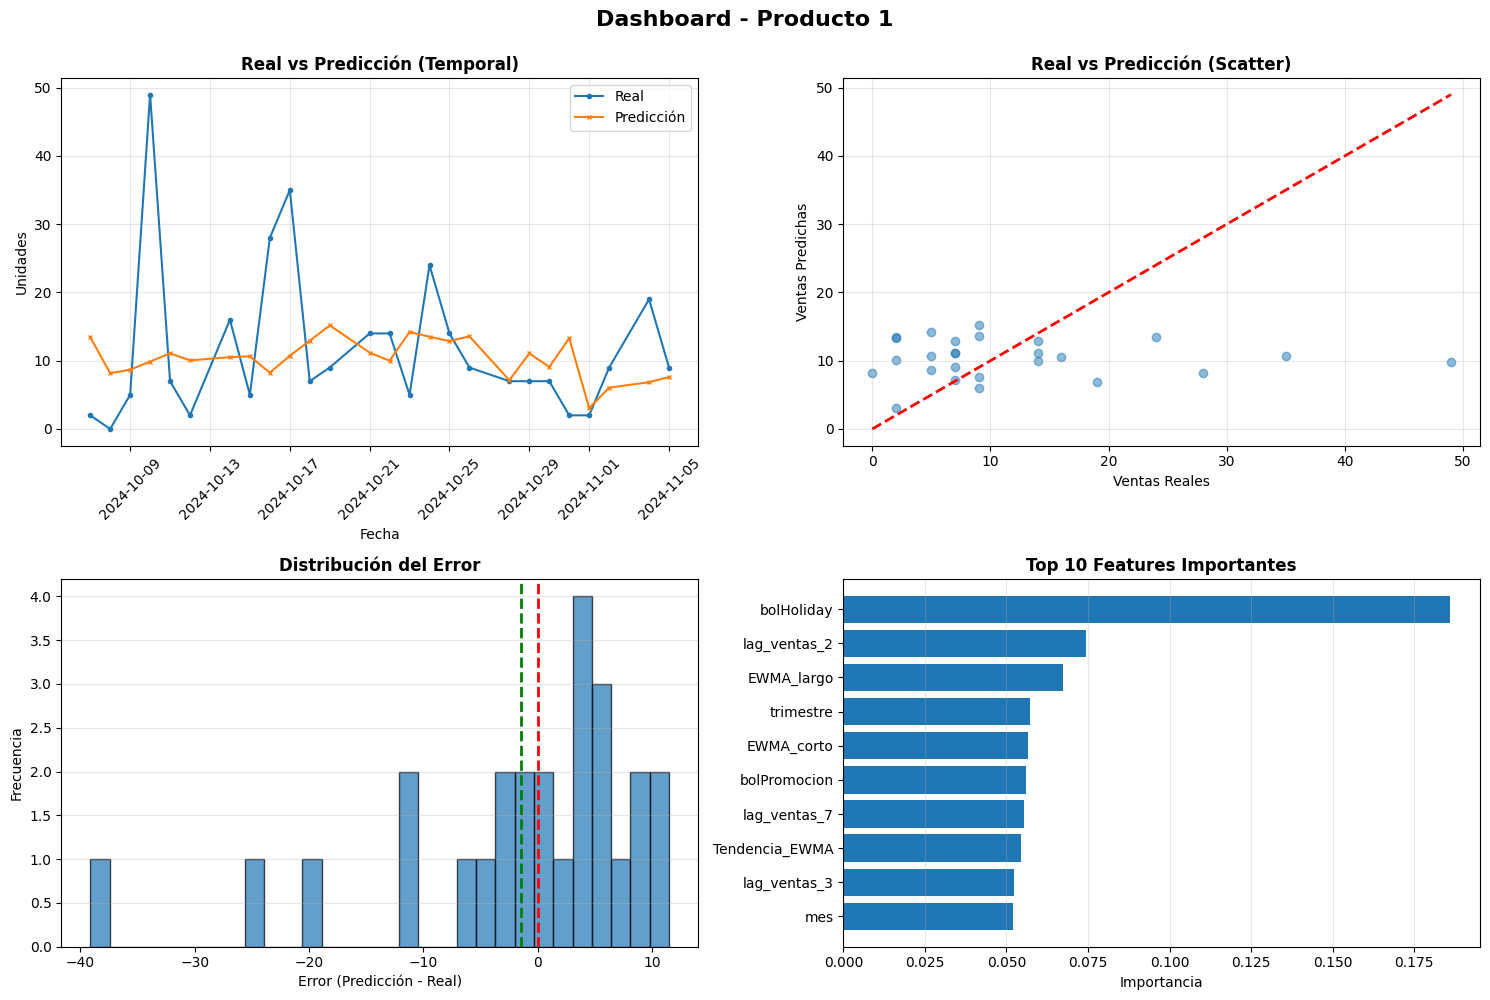


🔄 Entrenando modelo para Producto 2...
   ✓ MAE: 4.18 | RMSE: 5.16 | R²: -0.3022

   📌 Producto 2
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    6.252048 -0.747952   0.747952
    2024-10-08         7    5.927238 -1.072762   1.072762
    2024-10-09        16    6.989229 -9.010771   9.010771

   📊 Estadísticas del error:
      Error medio:              0.64
      Error abs medio:          4.18
      Error máximo:            11.13
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
  XGBoost Producto 2 4.1771 26.6228 5.1597 -0.3022     82.91      71.02 0.7169    66.22

🏆 Mejor modelo: XGBoost Producto 2 (RMSE: 5.1597)


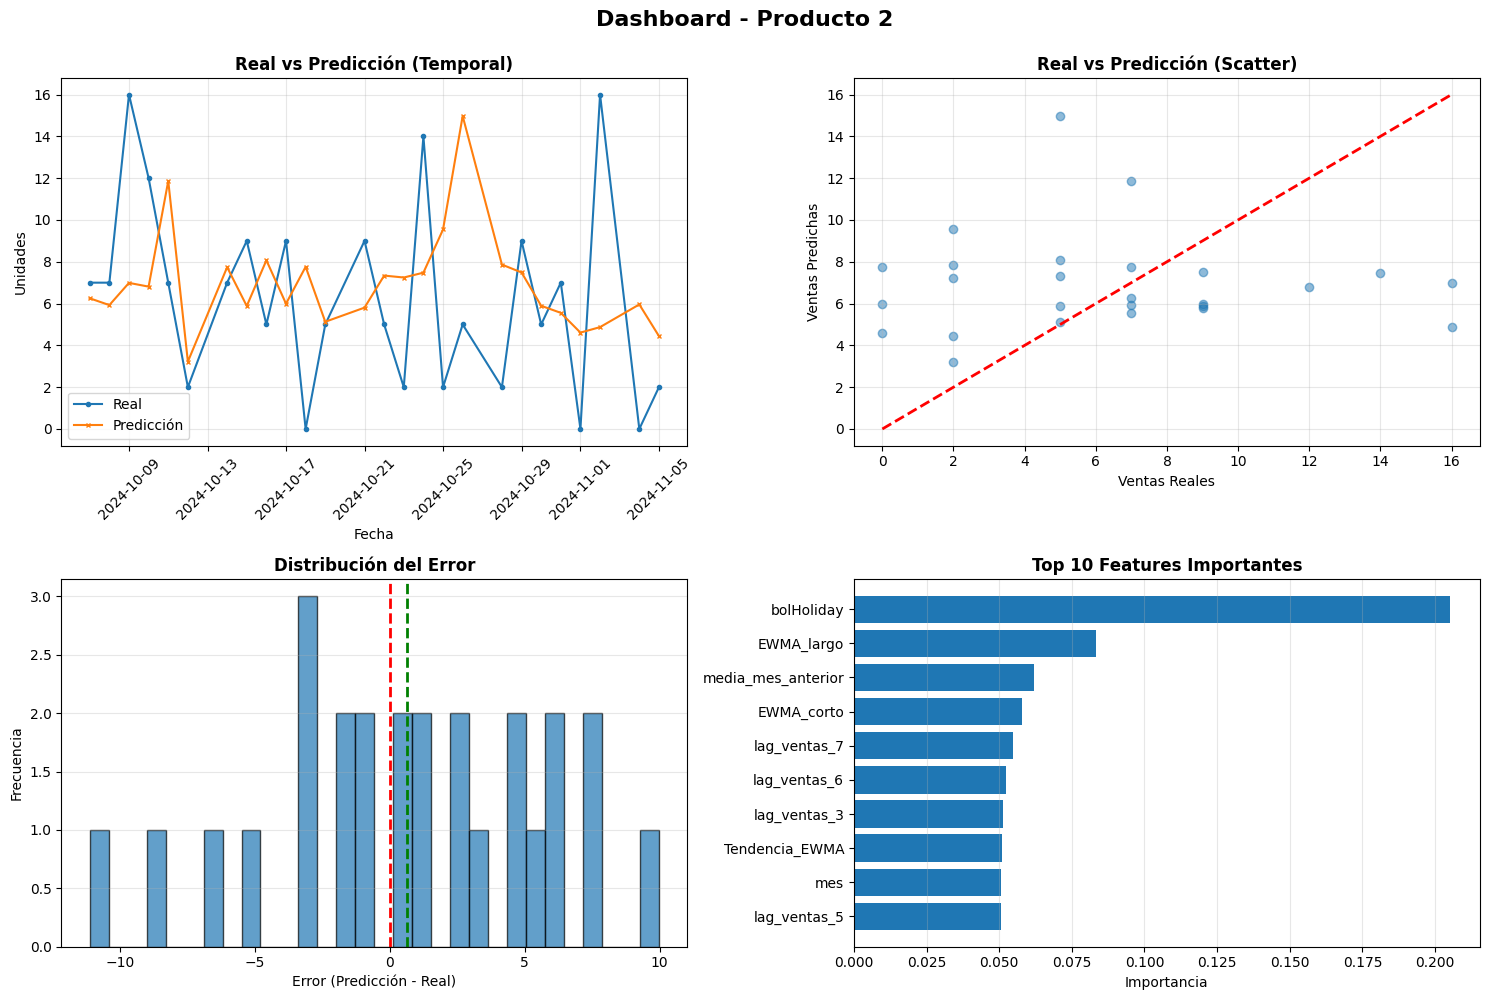


🔄 Entrenando modelo para Producto 9...
   ✓ MAE: 5.16 | RMSE: 5.80 | R²: -0.0919

   📌 Producto 9
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    8.247171 -0.752829   0.752829
    2024-10-08         2   12.316274 10.316274  10.316274
    2024-10-09         5   10.875752  5.875752   5.875752

   📊 Estadísticas del error:
      Error medio:              2.34
      Error abs medio:          5.16
      Error máximo:            10.32
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
  XGBoost Producto 9 5.1605 33.6121 5.7976 -0.0919    144.32      88.13 0.7745    80.34

🏆 Mejor modelo: XGBoost Producto 9 (RMSE: 5.7976)


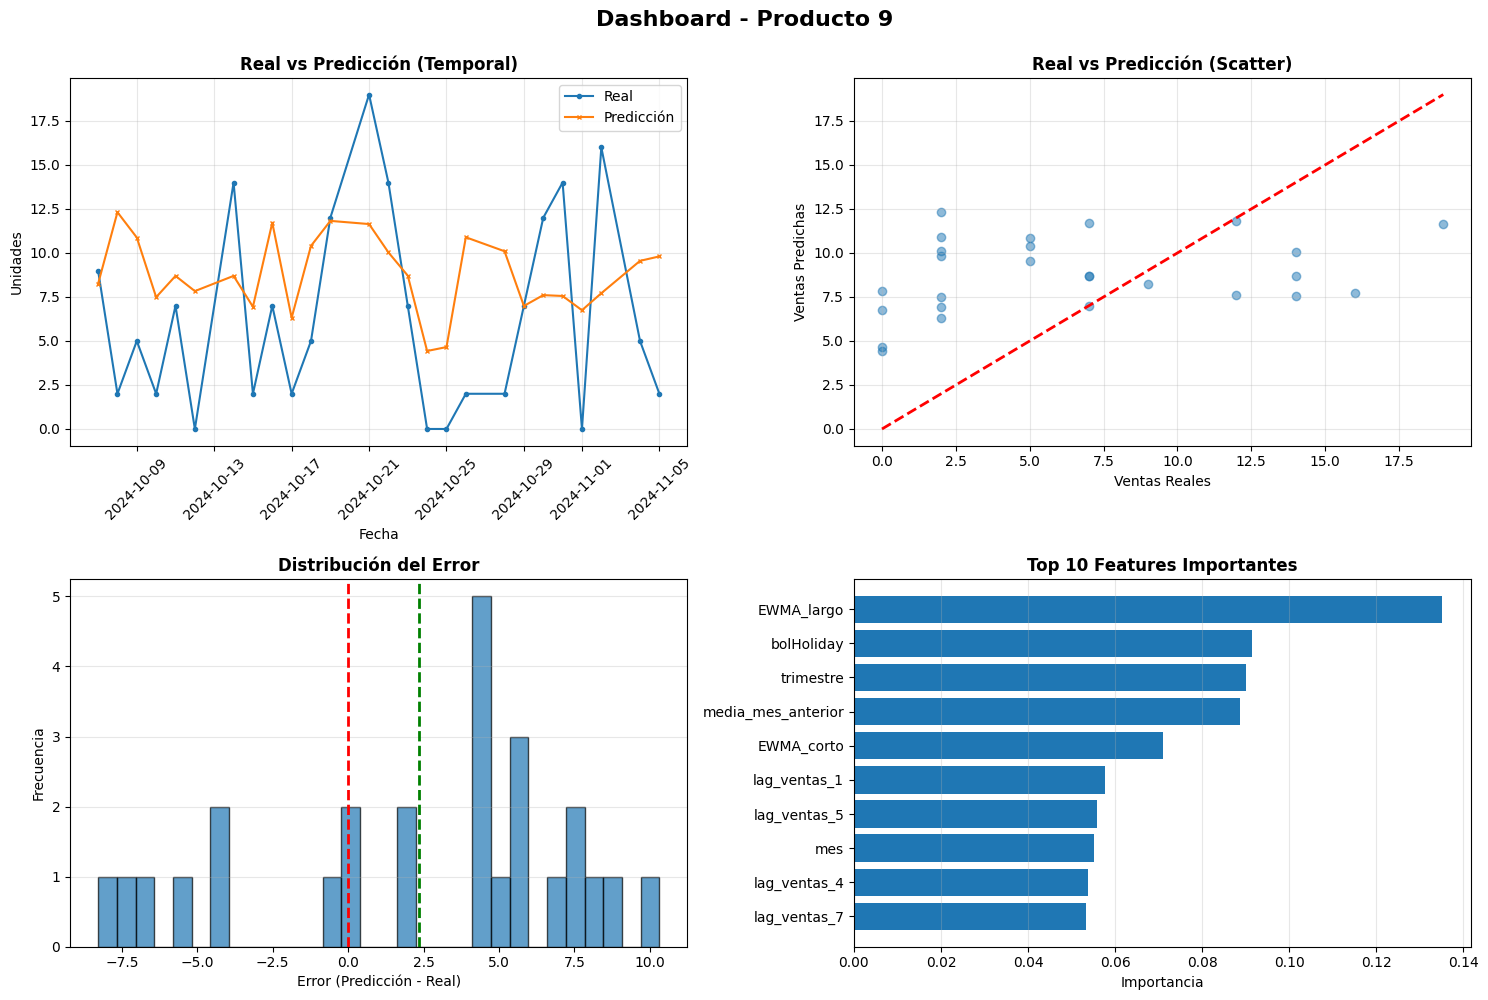


🔄 Entrenando modelo para Producto 78...
   ✓ MAE: 4.90 | RMSE: 6.34 | R²: 0.2164

   📌 Producto 78
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07        16   10.015645 -5.984355   5.984355
    2024-10-08        16    7.196439 -8.803561   8.803561
    2024-10-09        14   11.132612 -2.867388   2.867388

   📊 Estadísticas del error:
      Error medio:             -0.99
      Error abs medio:          4.90
      Error máximo:            20.37
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
 XGBoost Producto 78 4.8956 40.1902 6.3396 0.2164     59.81      60.04 0.6307    43.29

🏆 Mejor modelo: XGBoost Producto 78 (RMSE: 6.3396)


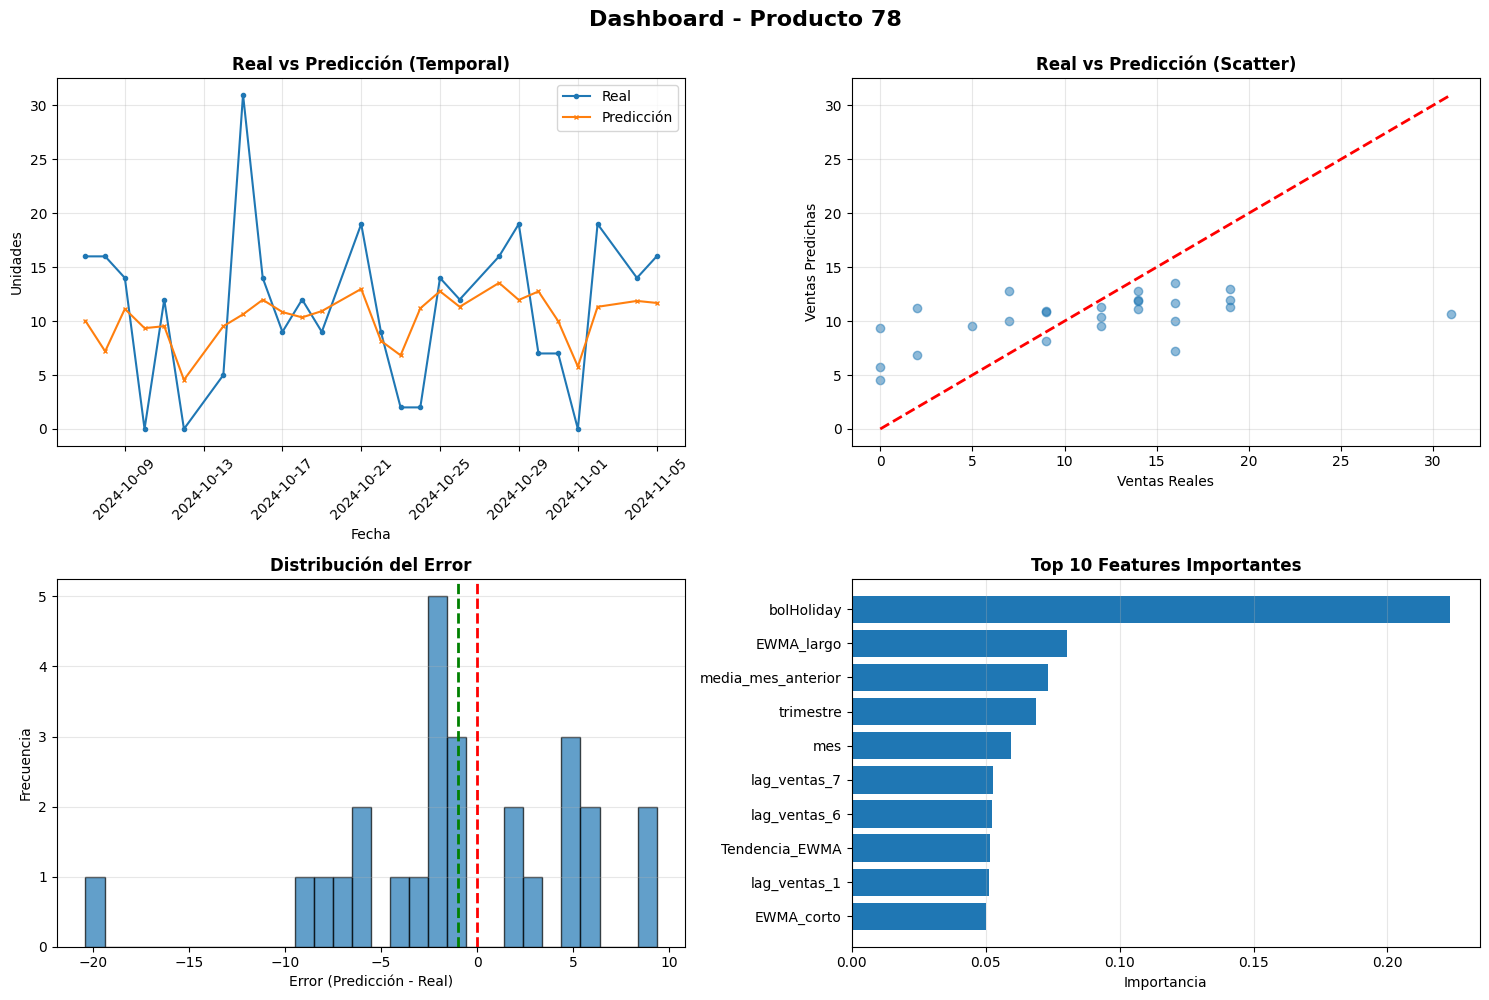


🔄 Entrenando modelo para Producto 7...
   ✓ MAE: 3.78 | RMSE: 4.08 | R²: -1.1619

   📌 Producto 7
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         0    5.085201 5.085201   5.085201
    2024-10-08         0    5.883513 5.883513   5.883513
    2024-10-09         0    6.389335 6.389335   6.389335

   📊 Estadísticas del error:
      Error medio:              2.76
      Error abs medio:          3.78
      Error máximo:             6.39
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
  XGBoost Producto 7 3.7778 16.6685 4.0827 -1.1619    114.49     119.56 0.9949   148.82

🏆 Mejor modelo: XGBoost Producto 7 (RMSE: 4.0827)


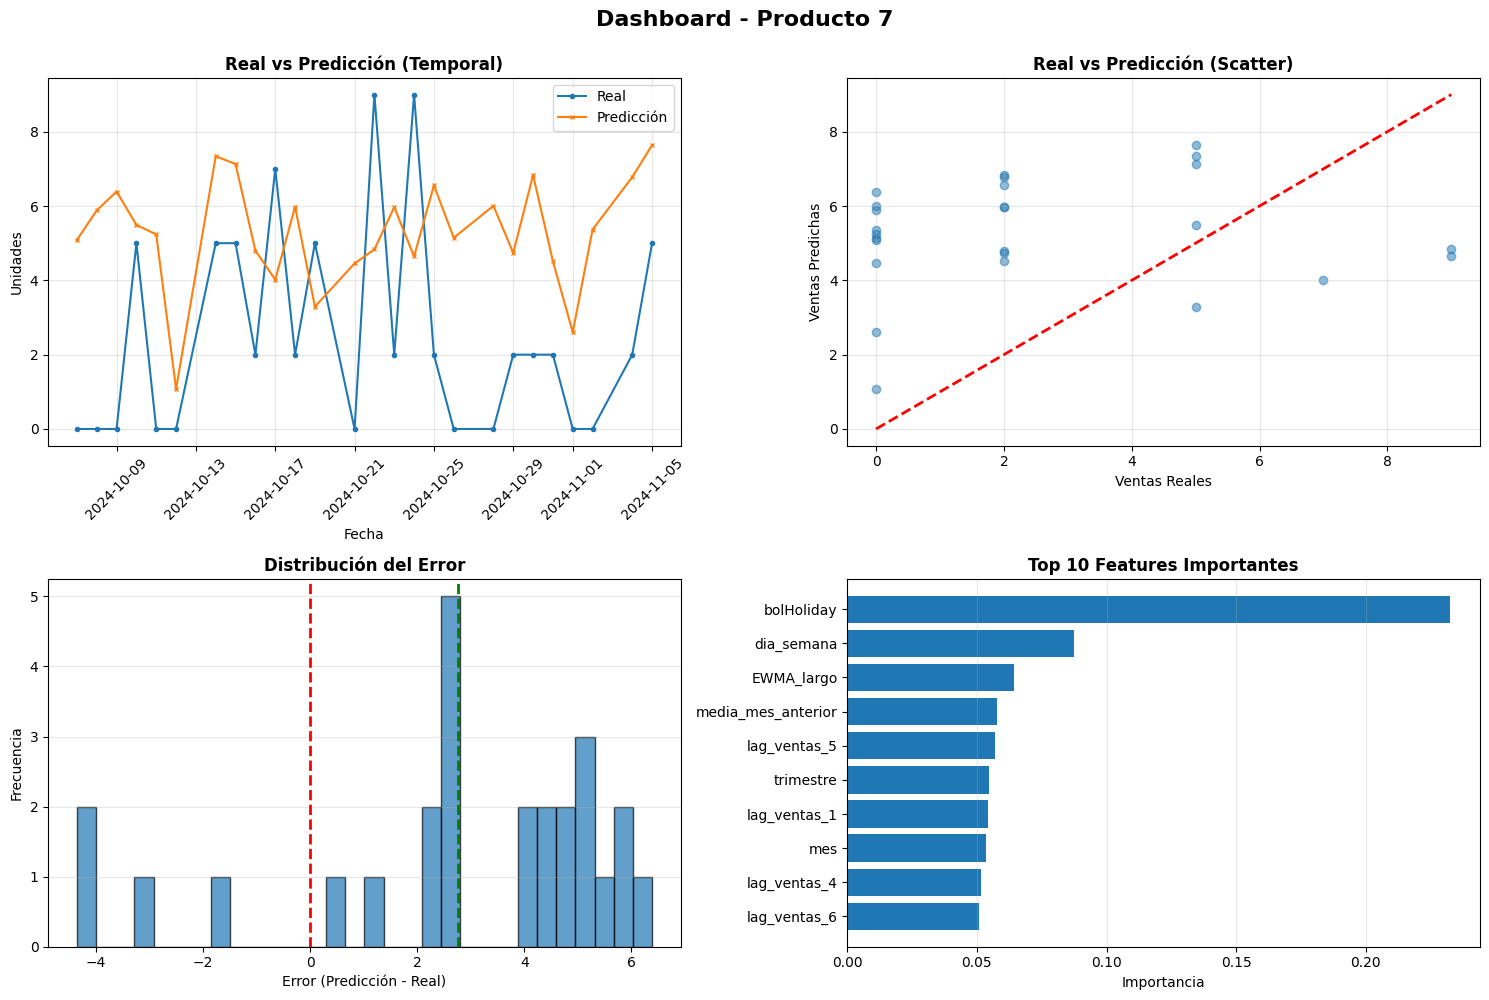


🔄 Entrenando modelo para Producto 13...
   ✓ MAE: 3.35 | RMSE: 4.05 | R²: -0.4168

   📌 Producto 13
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         2    6.939711 4.939711   4.939711
    2024-10-08         2    6.905966 4.905966   4.905966
    2024-10-09         2    6.501611 4.501611   4.501611

   📊 Estadísticas del error:
      Error medio:              1.56
      Error abs medio:          3.35
      Error máximo:            10.82
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
 XGBoost Producto 13 3.3506 16.3999 4.0497 -0.4168    100.34      83.87 0.7742    84.58

🏆 Mejor modelo: XGBoost Producto 13 (RMSE: 4.0497)


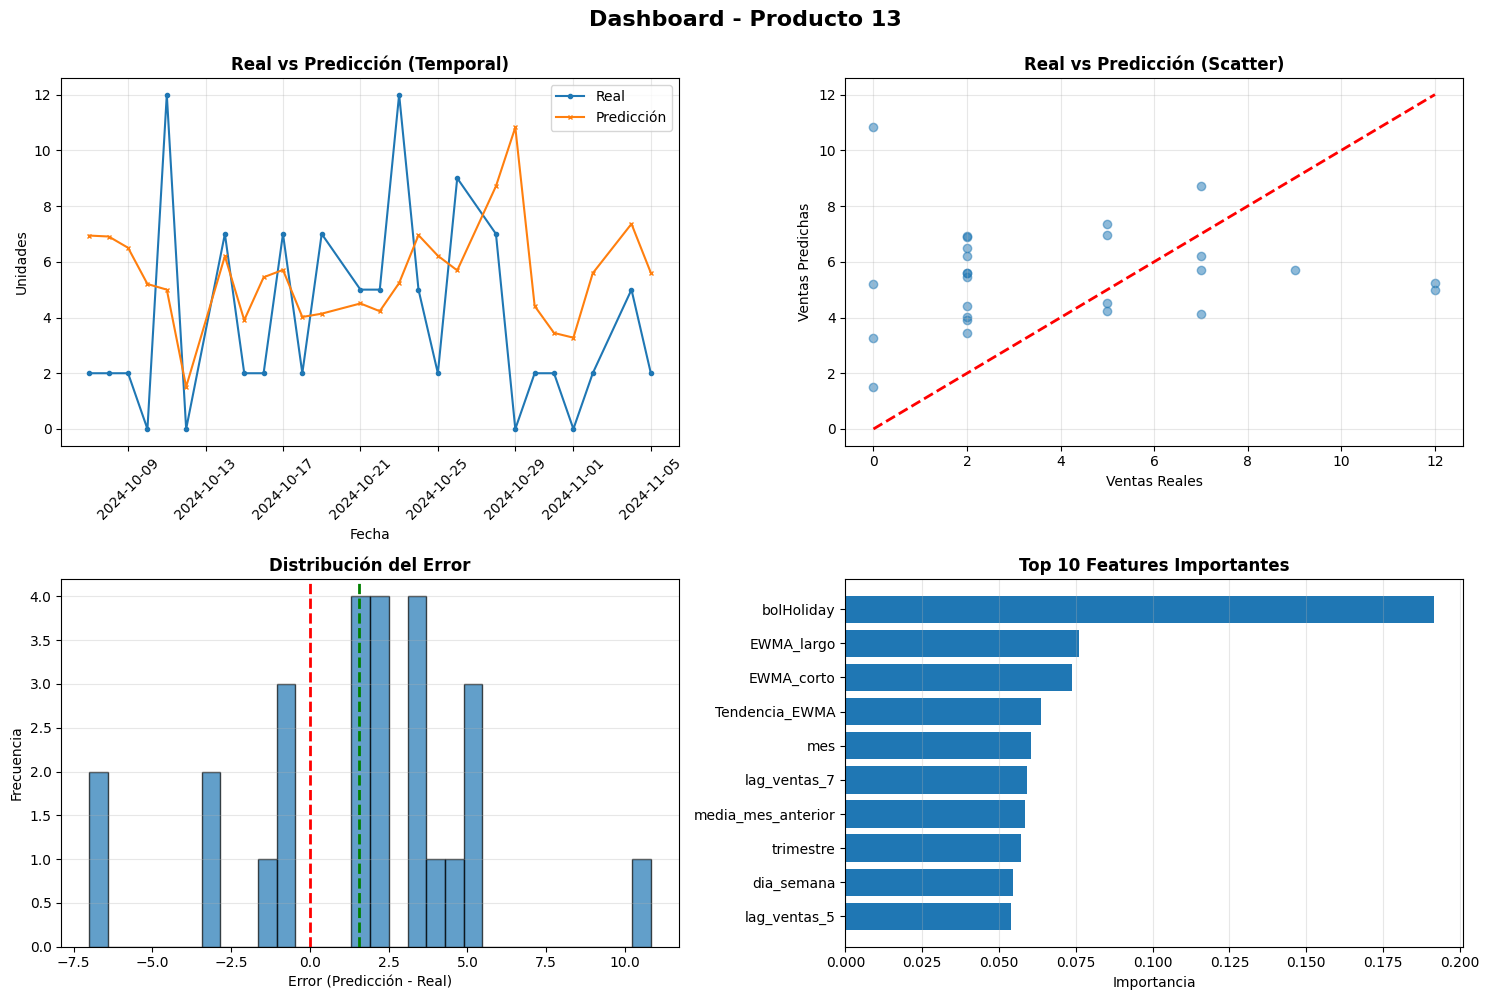


🔄 Entrenando modelo para Producto 15...
   ✓ MAE: 3.49 | RMSE: 4.39 | R²: -0.2039

   📌 Producto 15
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    7.075474  0.075474   0.075474
    2024-10-08         5    5.294164  0.294164   0.294164
    2024-10-09         9    5.290953 -3.709047   3.709047

   📊 Estadísticas del error:
      Error medio:             -0.32
      Error abs medio:          3.49
      Error máximo:             9.89
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
 XGBoost Producto 15 3.4865 19.2408 4.3864 -0.2039     66.91      76.29 0.8404    61.25

🏆 Mejor modelo: XGBoost Producto 15 (RMSE: 4.3864)


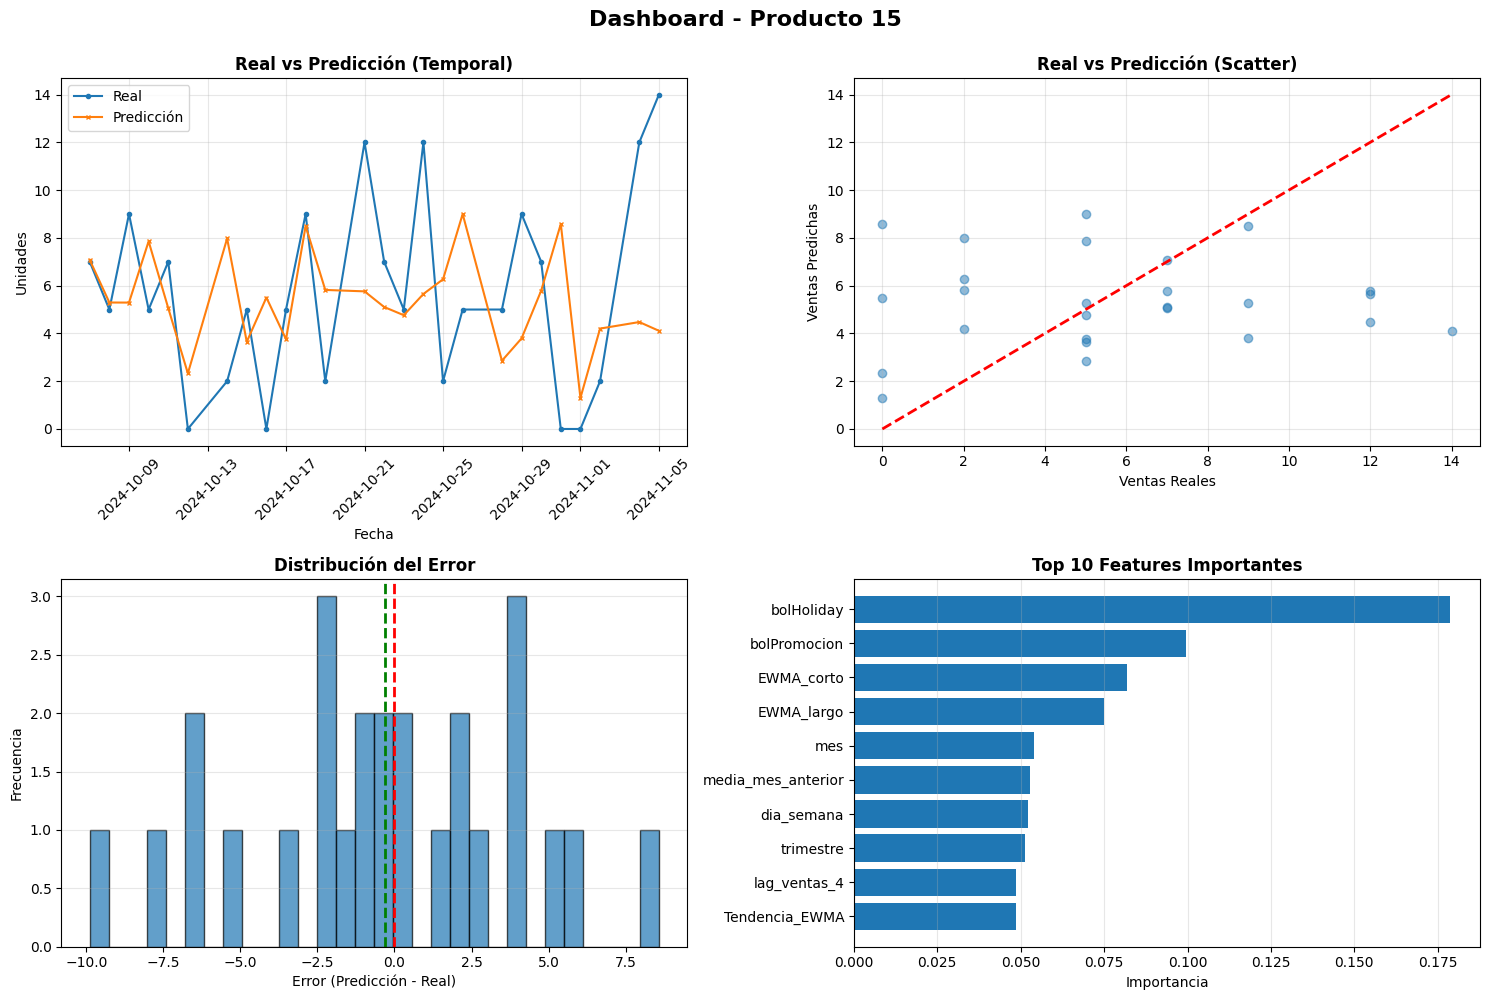


🔄 Entrenando modelo para Producto 391...
   ✓ MAE: 3.39 | RMSE: 4.04 | R²: -0.1508

   📌 Producto 391
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         5    5.514042  0.514042   0.514042
    2024-10-08         9    6.133037 -2.866963   2.866963
    2024-10-09         0    5.531414  5.531414   5.531414

   📊 Estadísticas del error:
      Error medio:              1.39
      Error abs medio:          3.39
      Error máximo:             8.95
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
XGBoost Producto 391 3.3861 16.2946 4.0367 -0.1508      82.6     106.09 0.7185   100.05

🏆 Mejor modelo: XGBoost Producto 391 (RMSE: 4.0367)


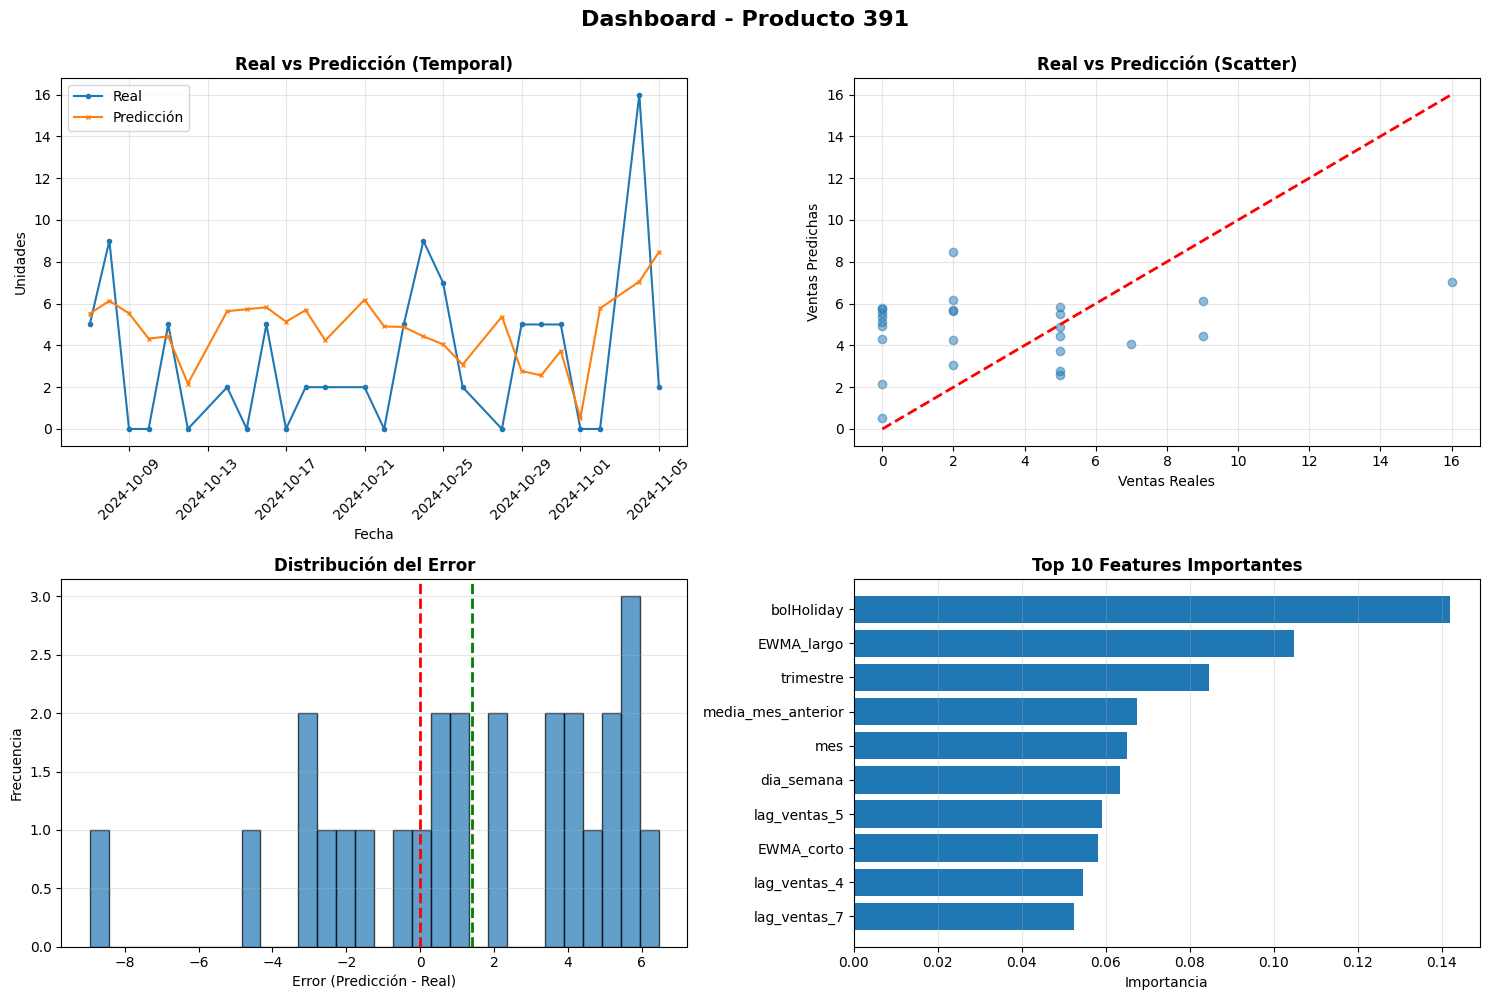


🔄 Entrenando modelo para Producto 3...
   ✓ MAE: 4.36 | RMSE: 5.52 | R²: -0.0043

   📌 Producto 3
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    5.240736 -1.759264   1.759264
    2024-10-08         5    4.262540 -0.737460   0.737460
    2024-10-09         5    4.009186 -0.990814   0.990814

   📊 Estadísticas del error:
      Error medio:             -0.59
      Error abs medio:          4.36
      Error máximo:            12.98
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
  XGBoost Producto 3 4.3609 30.4522 5.5184 -0.0043     73.62      85.36 0.9354    67.89

🏆 Mejor modelo: XGBoost Producto 3 (RMSE: 5.5184)


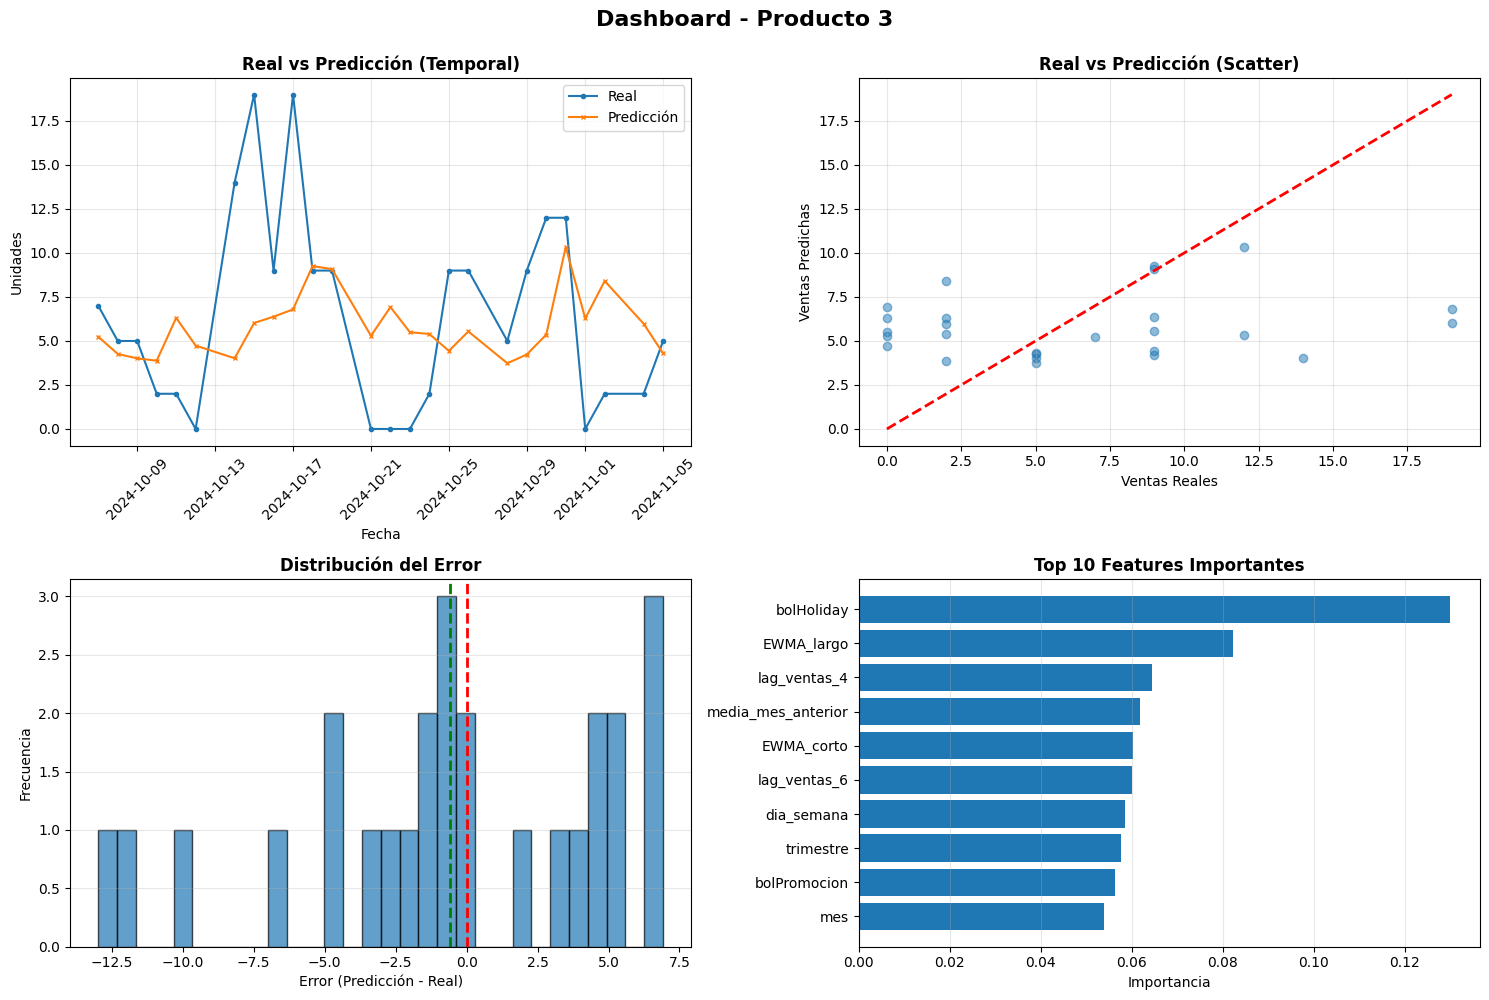


🔄 Entrenando modelo para Producto 131...
   ✓ MAE: 3.10 | RMSE: 3.74 | R²: 0.0605

   📌 Producto 131
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    5.983696 -3.016304   3.016304
    2024-10-08         9    7.650475 -1.349525   1.349525
    2024-10-09         2   10.197551  8.197551   8.197551

   📊 Estadísticas del error:
      Error medio:              0.76
      Error abs medio:          3.10
      Error máximo:             8.20
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
XGBoost Producto 131 3.1038 13.9886 3.7401 0.0605     65.72      97.75 0.7381    83.19

🏆 Mejor modelo: XGBoost Producto 131 (RMSE: 3.7401)


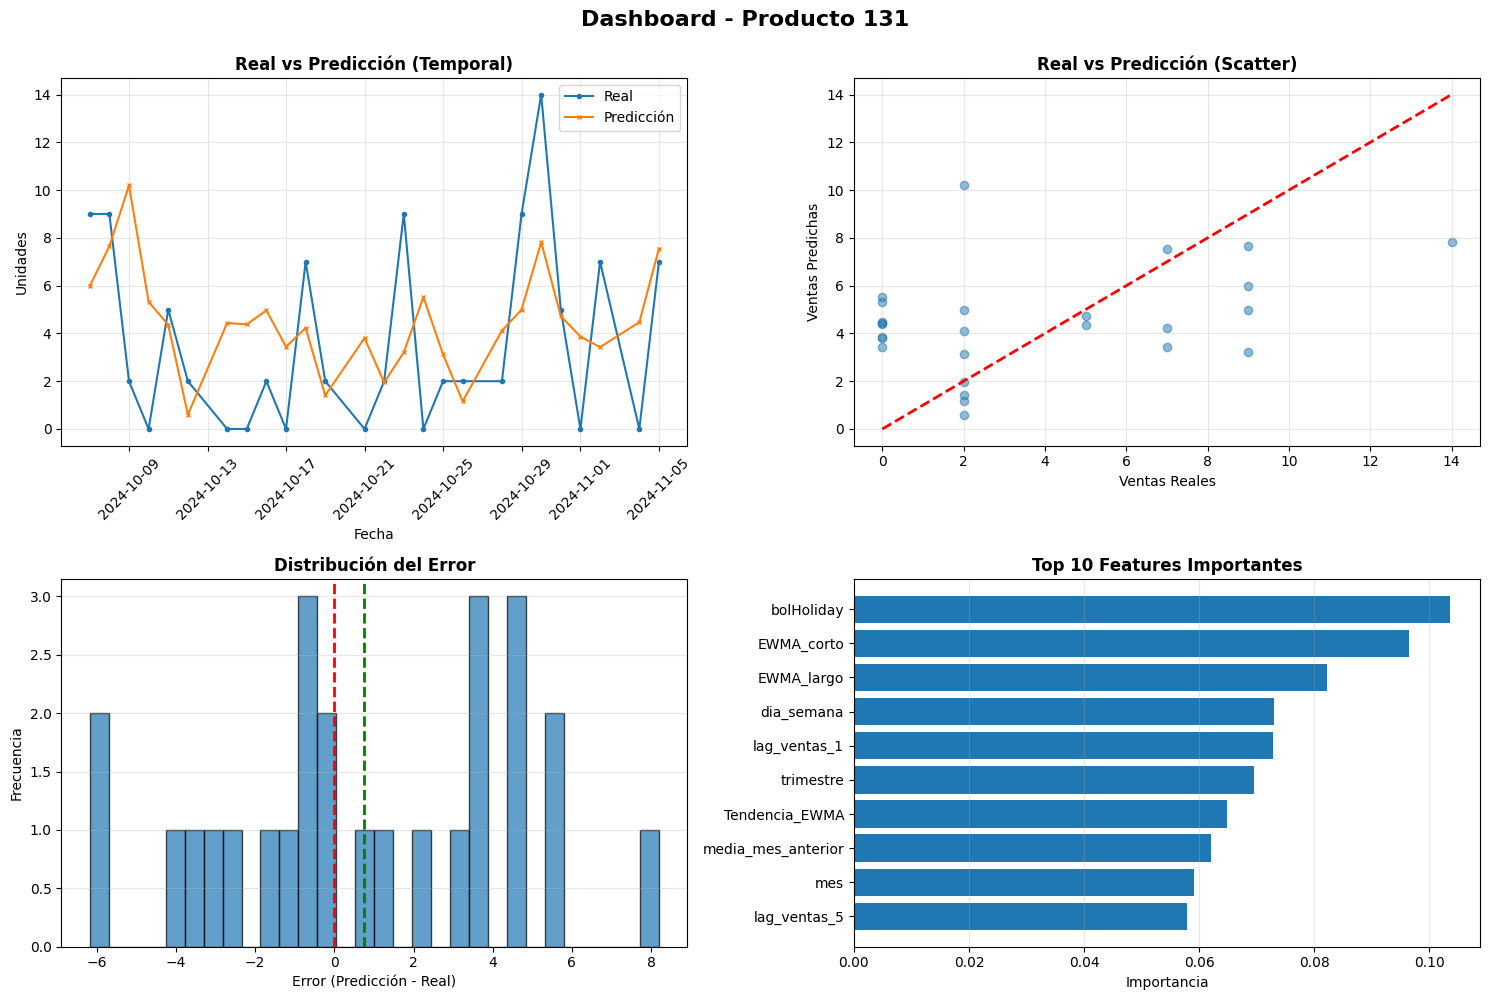

In [16]:

# ============================================================================
# 3. MODELOS POR PRODUCTO (TOP 10)
# ============================================================================

print("\n" + "="*100)
print("🔍 MODELO 3: XGBOOST POR PRODUCTO (TOP 10)")
print("="*100)

top_productos = df_train.groupby('producto')['udsVenta'].sum().nlargest(10).index.tolist()
print(f"\n🏆 Top 10 productos: {top_productos}")

modelos_producto = {}

for producto in top_productos:
    print(f"\n🔄 Entrenando modelo para Producto {producto}...")
    
    # Filtrar datos
    train_prod = df_train[df_train['producto'] == producto]
    test_prod = df_test[df_test['producto'] == producto].dropna()
    
    if len(test_prod) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    if len(train_prod) < 100:
        print(f"   ⚠️  Datos insuficientes ({len(train_prod)} registros)")
        continue
    
    X_train_p = train_prod[FEATURES]
    y_train_p = train_prod[TARGET]
    X_test_p = test_prod[FEATURES]
    y_test_p = test_prod[TARGET]
    
    # Entrenar
    xgb_producto = xgb.XGBRegressor(**best_params)
    
    xgb_producto.fit(X_train_p, y_train_p)
    y_pred_p = xgb_producto.predict(X_test_p)
    
    modelos_producto[producto] = xgb_producto
    
    # Calcular métricas
    metricas_producto = calcular_metricas(y_test_p, y_pred_p, f"XGBoost Producto {producto}")
    todas_metricas.append(metricas_producto)
    
    print(f"   ✓ MAE: {metricas_producto['MAE']:.2f} | RMSE: {metricas_producto['RMSE']:.2f} | R²: {metricas_producto['R2']:.4f}")
    
    # Preparar datos
    test_prod_pred = test_prod.copy()
    test_prod_pred['prediccion'] = y_pred_p
    test_prod_pred['error'] = y_pred_p - test_prod_pred[TARGET]
    test_prod_pred['error_abs'] = np.abs(test_prod_pred['error'])
    test_prod_pred['error_pct'] = (test_prod_pred['error_abs'] / test_prod_pred[TARGET]) * 100
    test_prod_pred = test_prod_pred.sort_values('idSecuencia')
    
    print(f"\n   📌 Producto {producto}")
    print(f"      Train: {len(train_prod)} | Test: {len(test_prod_pred)}")
    
    # Primeras predicciones
    print(f"\n   📋 Primeras 3 predicciones:")
    cols = ['idSecuencia', TARGET, 'prediccion', 'error', 'error_abs']
    print("   " + test_prod_pred[cols].head(3).to_string(index=False).replace('\n', '\n   '))
    
    # Estadísticas
    print(f"\n   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_prod_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_prod_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_prod_pred['error_abs'].max():>8.2f}")
    print(f"      Error % medio:        {test_prod_pred['error_pct'].mean():>8.2f}%")
    
    if len(test_prod_pred) >= 2:
        resumen_metricas([metricas_producto])
        
        try:
            dashboard_prediccion(
                df=test_prod_pred,
                col_fecha='idSecuencia',
                col_real=TARGET,
                col_pred='prediccion',
                modelo=xgb_producto,
                feature_names=FEATURES,
                titulo_principal=f'Dashboard - Producto {producto}',
                figsize=(15, 10)
            )
        except Exception as e:
            print(f"   ⚠️  Error en dashboard: {str(e)}")


# Resumen final


🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS

📊 Resumen de todas las métricas:

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE    RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
   XGBoost Cluster 3 1.0777   2.7621  1.6620  0.0745     55.50     169.01 0.7458   132.71
 XGBoost Global Test 1.5740   5.6596  2.3790  0.2614     49.26     144.28 0.7291    96.39
   XGBoost Cluster 0 1.8020   6.5639  2.5620  0.1083     39.49     125.49 0.7365    93.32
   XGBoost Cluster 1 2.8118  13.0619  3.6141  0.1312     56.10      98.69 0.7223    73.74
XGBoost Producto 131 3.1038  13.9886  3.7401  0.0605     65.72      97.75 0.7381    83.19
XGBoost Producto 391 3.3861  16.2946  4.0367 -0.1508     82.60     106.09 0.7185   100.05
 XGBoost Producto 13 3.3506  16.3999  4.0497 -0.4168    100.34      83.87 0.7742    84.58
  XGBoost Producto 7 3.7778  16.6685  4.0827 -1.1619    114.49     119.56 0.9949   148.82
 XGBoost Producto 15 3.4865  19.2408  4.3864 -0.2039     66.91      76.29 0.8404 

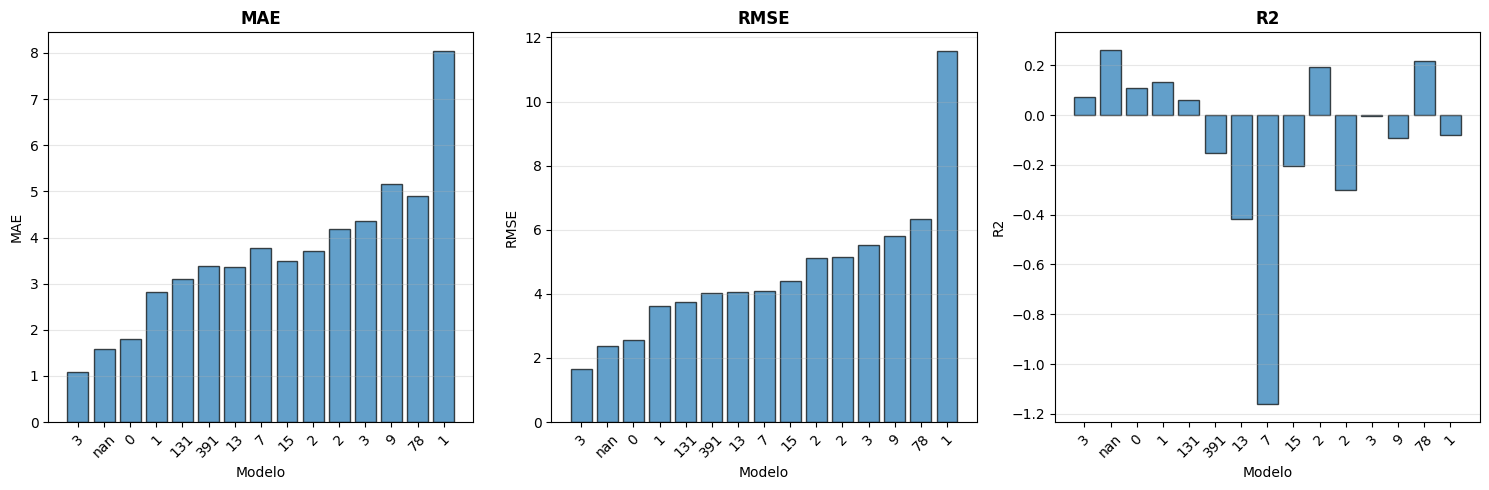


📊 ANÁLISIS POR CATEGORÍAS DE MODELOS

🌐 MODELOS GLOBALES:
          Algoritmo   MAE  RMSE     R2
XGBoost Global Test 1.574 2.379 0.2614

   Promedio RMSE: 2.38

🎯 MODELOS POR CLUSTER:
        Algoritmo    MAE   RMSE     R2
XGBoost Cluster 3 1.0777 1.6620 0.0745
XGBoost Cluster 0 1.8020 2.5620 0.1083
XGBoost Cluster 1 2.8118 3.6141 0.1312
XGBoost Cluster 2 3.7089 5.1129 0.1922

   Promedio RMSE: 3.24
   Mejor cluster: XGBoost Cluster 3 (RMSE: 1.66)
   Peor cluster: XGBoost Cluster 2 (RMSE: 5.11)

🛒 MODELOS POR PRODUCTO:
           Algoritmo    MAE    RMSE      R2
XGBoost Producto 131 3.1038  3.7401  0.0605
XGBoost Producto 391 3.3861  4.0367 -0.1508
 XGBoost Producto 13 3.3506  4.0497 -0.4168
  XGBoost Producto 7 3.7778  4.0827 -1.1619
 XGBoost Producto 15 3.4865  4.3864 -0.2039
  XGBoost Producto 2 4.1771  5.1597 -0.3022
  XGBoost Producto 3 4.3609  5.5184 -0.0043
  XGBoost Producto 9 5.1605  5.7976 -0.0919
 XGBoost Producto 78 4.8956  6.3396  0.2164
  XGBoost Producto 1 8.0452 11.580

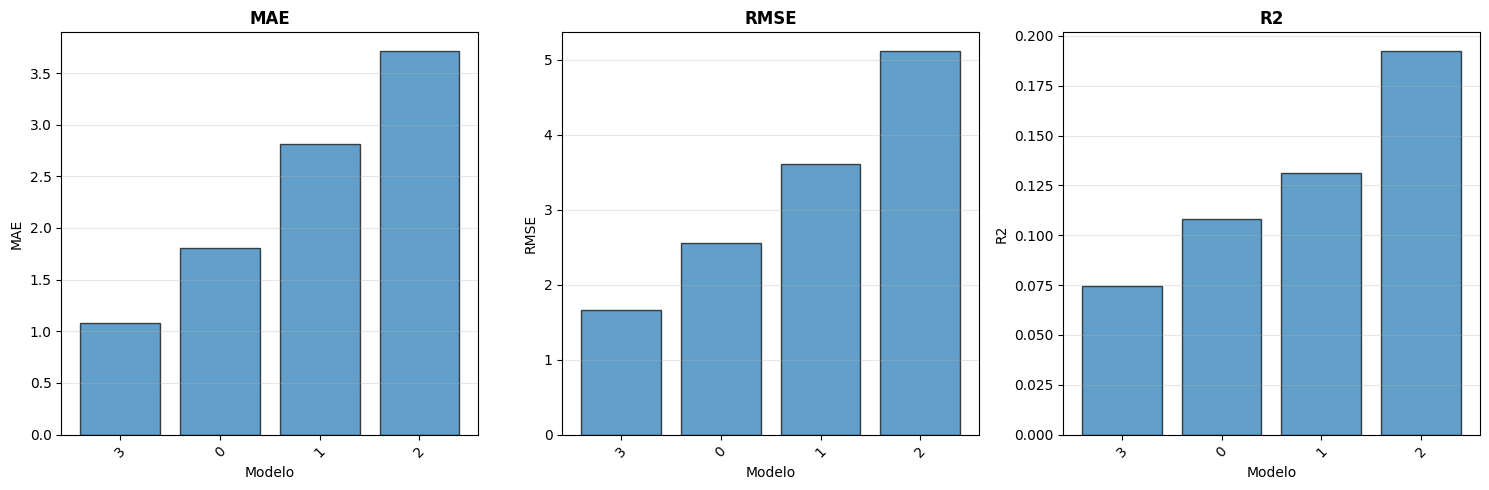


📊 Comparación entre productos:


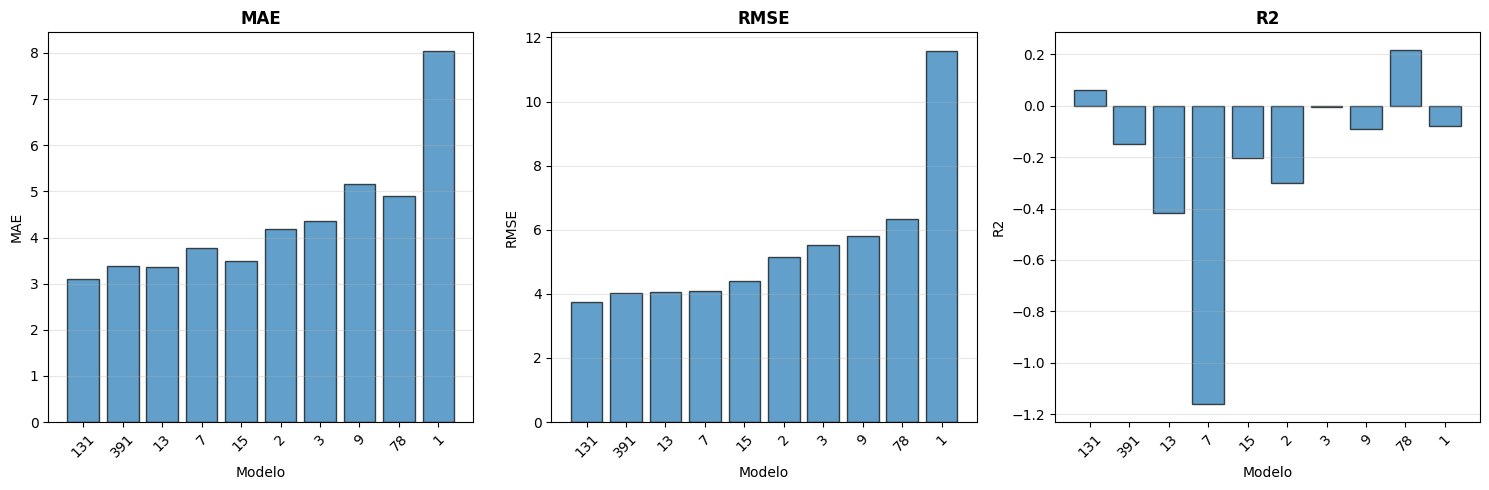


✅ ANÁLISIS COMPLETO FINALIZADO

📊 Total de modelos evaluados: 15
   - Modelos globales: 1
   - Modelos por cluster: 4
   - Modelos por producto: 10


In [17]:

# ============================================================================
# 4. RESUMEN FINAL DE TODOS LOS MODELOS
# ============================================================================

print("\n" + "="*100)
print("🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS")
print("="*100)

if todas_metricas:
    # Mostrar tabla completa de métricas
    print("\n📊 Resumen de todas las métricas:")
    resumen_metricas(todas_metricas)
    
    # Comparar métricas
    df_comparacion_final = comparar_metricas(todas_metricas, ordenar_por='RMSE')
    
    print("\n" + "="*100)
    print("📈 RANKING DE MODELOS POR RMSE")
    print("="*100)
    print(df_comparacion_final[['Algoritmo', 'MAE', 'RMSE', 'R2', 'MAPE (%)']].to_string(index=False))
    
    # Gráfico comparativo de TODOS los modelos
    print("\n📊 Generando gráficos comparativos...")
    grafico_comparacion_metricas(df_comparacion_final, metricas=['MAE', 'RMSE', 'R2'])
    
    # Análisis por categorías
    print("\n" + "="*100)
    print("📊 ANÁLISIS POR CATEGORÍAS DE MODELOS")
    print("="*100)
    
    # Separar por tipo de modelo
    df_global = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Global')]
    df_clusters = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Cluster')]
    df_productos = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Producto')]
    
    print("\n🌐 MODELOS GLOBALES:")
    if len(df_global) > 0:
        print(df_global[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_global['RMSE'].mean():.2f}")
    
    print("\n🎯 MODELOS POR CLUSTER:")
    if len(df_clusters) > 0:
        print(df_clusters[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_clusters['RMSE'].mean():.2f}")
        print(f"   Mejor cluster: {df_clusters.iloc[0]['Algoritmo']} (RMSE: {df_clusters.iloc[0]['RMSE']:.2f})")
        print(f"   Peor cluster: {df_clusters.iloc[-1]['Algoritmo']} (RMSE: {df_clusters.iloc[-1]['RMSE']:.2f})")
    
    print("\n🛒 MODELOS POR PRODUCTO:")
    if len(df_productos) > 0:
        print(df_productos[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_productos['RMSE'].mean():.2f}")
        print(f"   Mejor producto: {df_productos.iloc[0]['Algoritmo']} (RMSE: {df_productos.iloc[0]['RMSE']:.2f})")
        print(f"   Peor producto: {df_productos.iloc[-1]['Algoritmo']} (RMSE: {df_productos.iloc[-1]['RMSE']:.2f})")
    
    # Mejor modelo general
    print("\n" + "="*100)
    print("🥇 MEJOR MODELO GENERAL")
    print("="*100)
    mejor_idx = df_comparacion_final['RMSE'].idxmin()
    mejor_modelo = df_comparacion_final.loc[mejor_idx]
    
    print(f"\n🏆 {mejor_modelo['Algoritmo']}")
    print(f"   MAE:        {mejor_modelo['MAE']:.2f}")
    print(f"   RMSE:       {mejor_modelo['RMSE']:.2f}")
    print(f"   R²:         {mejor_modelo['R2']:.4f}")
    print(f"   MAPE:       {mejor_modelo['MAPE (%)']:.2f}%")
    print(f"   SMAPE:      {mejor_modelo['SMAPE (%)']:.2f}%")
    
    # Gráficos comparativos por categoría
    if len(df_clusters) > 1:
        print("\n📊 Comparación entre clusters:")
        grafico_comparacion_metricas(df_clusters, metricas=['MAE', 'RMSE', 'R2'])
    
    if len(df_productos) > 1:
        print("\n📊 Comparación entre productos:")
        grafico_comparacion_metricas(df_productos, metricas=['MAE', 'RMSE', 'R2'])
    
else:
    print("\n⚠️  No se generaron métricas para ningún modelo")

print("\n" + "="*100)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*100)
print(f"\n📊 Total de modelos evaluados: {len(todas_metricas)}")
print(f"   - Modelos globales: {len([m for m in todas_metricas if 'Global' in m['Algoritmo']])}")
print(f"   - Modelos por cluster: {len([m for m in todas_metricas if 'Cluster' in m['Algoritmo']])}")
print(f"   - Modelos por producto: {len([m for m in todas_metricas if 'Producto' in m['Algoritmo']])}")

# Salvar resultados

In [18]:
# salvar resultados en fichero
df_resultados = pd.DataFrame(todas_metricas)
df_resultados.to_csv('datos/resultados_metricas_xgboost.csv', index=False)